We first set up our environment:

In [20]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
import utils as ut

Now to bring in our data. By looking at it online you can see it doesn't have column names. It is also possible to notice that the last column is probably a month since it goes from 1 to 12 and repeats and the second to last is clearly a year. After some cross referencing with data online, the first is probably the unemployment rate in percentages and the second is the HWI (help wanted index, more info here: https://www.investopedia.com/terms/h/helpwantedindex.asp):

In [21]:
url = 'https://www.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts2/m-unemhelp.txt'

us_unem = pd.read_table(url, sep='\s+', names=['unem_rate', 'hwi', 'year', 'month'])

us_unem.head()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/f5/jdc2n89x0r11q0l7zdg17s9w0000gn/T/ipykernel_37638/2165220030.py:3: SyntaxWarning: invalid escape sequence '\s'
  us_unem = pd.read_table(url, sep='\s+', names=['unem_rate', 'hwi', 'year', 'month'])


,unem_rate,hwi,year,month
0,3.7,40.0,1951.0,1.0
1,3.4,41.0,1951.0,2.0
2,3.4,43.0,1951.0,3.0
3,3.1,42.0,1951.0,4.0
4,3.0,43.0,1951.0,5.0


The first thing we want to do is to convert the year and month column into one 'date' column with the 'datetime' data type. First we check if there are any empty values:

In [22]:
us_unem.isnull().any()

unem_rate    False
hwi          False
year         False
month        False
dtype: bool

We transform:

In [23]:
# To date time method expects a day column
us_unem['day'] = 1.0

date_cols = ['year', 'month', 'day']
us_unem['date'] = pd.to_datetime(us_unem[date_cols], format='')
us_unem.drop(date_cols, axis=1, inplace=True)
us_unem.head()

,unem_rate,hwi,date
0,3.7,40.0,1951-01-01
1,3.4,41.0,1951-02-01
2,3.4,43.0,1951-03-01
3,3.1,42.0,1951-04-01
4,3.0,43.0,1951-05-01


Next we want to look at the time, ACF and PACF plot for our unemployment rate:

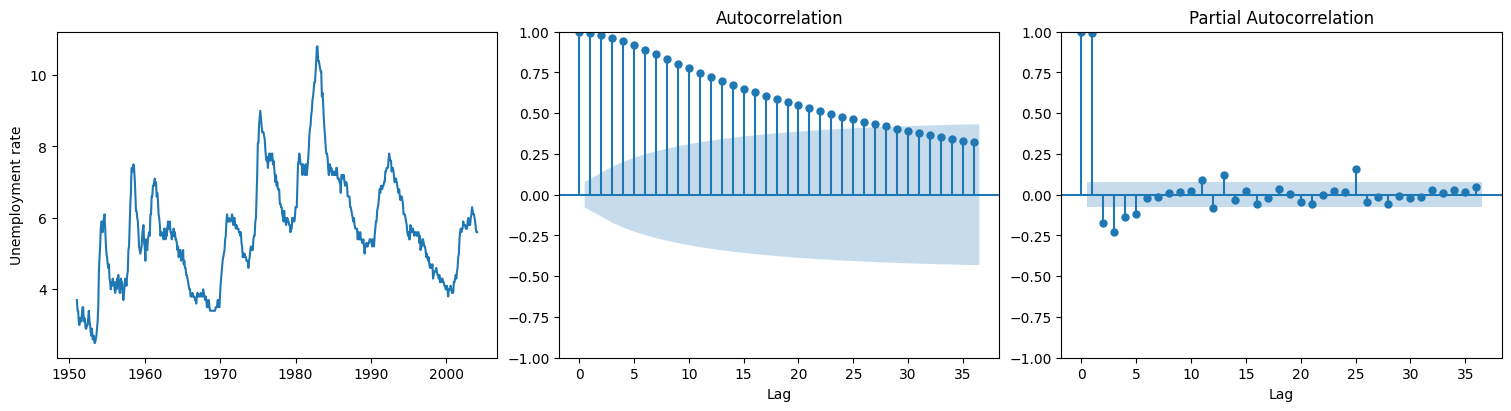

In [24]:
ut.plot_time_acf_pacf(us_unem['date'], us_unem['unem_rate'])

We can see that the ACF is slowly decreasing while still being significant at the 5% level even until lag ~ 27, which can point at non-stationarity. Another thing to notice is that the series doesn't seem to show any clear deterministic time trend. Thus we'll run an augmented Dickey-Fuller test to check non-stationarity with only a constant term:

In [25]:
from statsmodels.tsa.stattools import adfuller
adfuller(us_unem['unem_rate'], regression='ct')[1]

np.float64(0.15211216167326314)

We see that the p value is greater then the 5% significance level, we can accept the null and assert the existence of a unit root. Let's difference and plot:

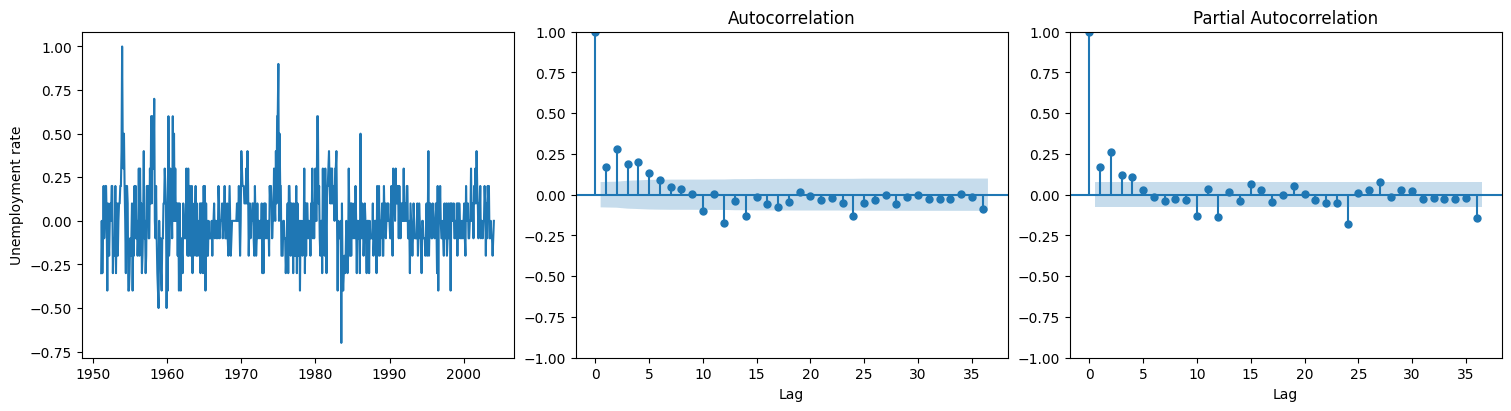

In [26]:
us_unem['diff_unem_rate'] = us_unem['unem_rate'].diff()
ut.plot_time_acf_pacf(us_unem[1:]['date'], us_unem[1:]['diff_unem_rate'])

The first thing to notice is that the differenced series seems to be stationary, as the auto-correlations are now much smaller and decrease relatively fast. Lets run an ADF test again to check:

In [27]:
adfuller(us_unem['diff_unem_rate'][1:], regression='ct')[1]

np.float64(7.207471527062938e-11)

 The result is very significant at the 5% level so we can confidently assert stationarity. We can also notice persistent significant auto-correlations at lags: 12, 24 ,36. This might point at seasonality even though we were told the data is seasonally adjusted. Before choosing a model to fit, lets try to look at the plots for $(1 - L^12)(1 - L)r_t$ (seasonally difference the difference series):

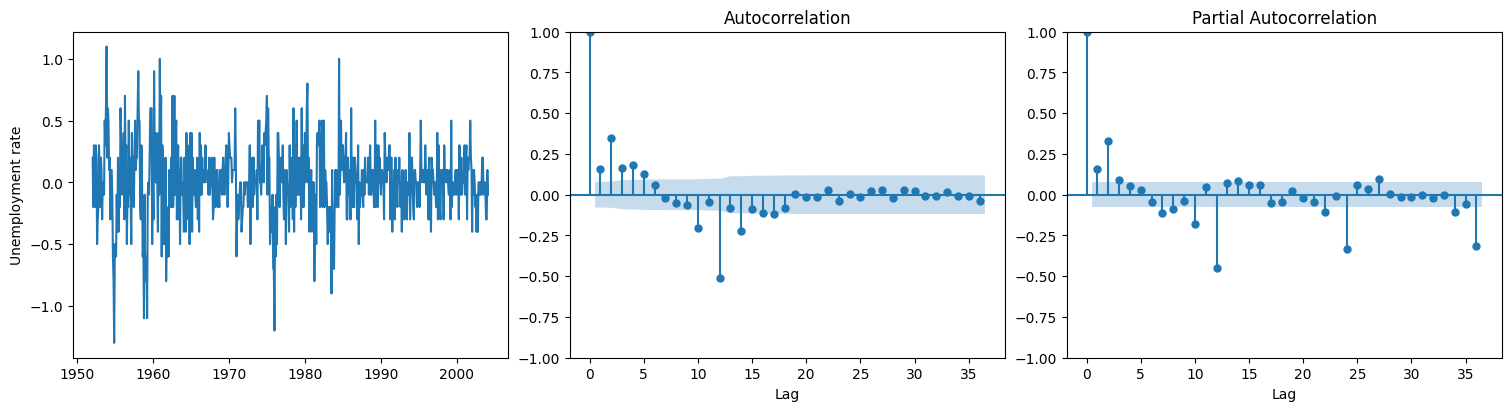

In [28]:
us_unem['seasonal_diff_unem_rate'] = us_unem['diff_unem_rate'].diff(12)
ut.plot_time_acf_pacf(us_unem[13:]['date'], us_unem[13:]['seasonal_diff_unem_rate'])

Since the second differencing seems to have increased noise and size of negative seasonal lags, we have a good reason to believe we over differenced. Thus, we will go back to the original differenced sequence and try to fit different ARMA models to it with a form of grid search: